#### **Import Packages**

In [65]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, brier_score_loss, roc_curve, roc_auc_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import svm
from keras.src.models import Sequential
from keras.src.layers import LSTM, Dense, Dropout, Input
from sklearn.preprocessing import StandardScaler
from keras.src.optimizers import Adam

### **Metrics and Their Formulas**

#### True Positive Rate (TPR) or Recall
Also called Sensitivity.
$$
TPR = \frac{TP}{TP + FN}
$$

#### True Negative Rate (TNR) or Specificity
$$
TNR = \frac{TN}{TN + FP}
$$

#### False Positive Rate (FPR)
$$
FPR = \frac{FP}{FP + TN}
$$

#### False Negative Rate (FNR)
$$
FNR = \frac{FN}{TP + FN}
$$

#### Precision
$$
Precision = \frac{TP}{TP + FP}
$$

#### Recall (Alternative Name for TPR)
$$
Recall = \frac{TP}{TP + FN}
$$

#### Accuracy
$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

#### F1 Score
Harmonic mean of Precision and Recall:
$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} = 
$$
$$
F1 = 2 \cdot \frac{TP}{2 \cdot TP + FP + FN}
$$

#### Error Rate
$$
Error\ Rate = \frac{FP + FN}{TP + TN + FP + FN}
$$

#### Balanced Accuracy (BACC)
$$
BACC = \frac{TPR + TNR}{2} = \frac{1}{2} \left( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} \right)
$$

#### True Skill Statistics (TSS)
TSS measures the difference between recall and the probability of false detection.
$$
TSS = \frac{TP}{TP + FN} - \frac{FP}{FP + TN}
$$

#### Heidke Skill Score (HSS)
HSS measures the fractional prediction over random prediction.
$$
HSS = \frac{2(TP \cdot TN - FP \cdot FN)}{(TP + FN) \cdot (FN + TN) + (TP + FP) \cdot (FP + TN)}
$$

In [66]:
def calculate_metrics(FP, FN, TP, TN):
    P = TP + FN
    N = TN + FP

    TPR = TP/P if P != 0 else 0
    TNR = TN/N if N != 0 else 0
    FPR = FP/N if N != 0 else 0
    FNR = FN/P if P != 0 else 0

    recall = TPR
    precision = TP/(TP+FP) if (TP+FP) != 0 else 0
    F1 = (2*TP)/(2*TP+FP+FN) if (2*TP+FP+FN) != 0 else 0
    accuracy = (TP+TN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) != 0 else 0
    error_rate = (FP+FN)/(TP+TN+FP+FN) if (TP+TN+FP+FN) != 0 else 0

    BACC = (TPR+TNR)/2
    TSS = (TP/(TP+FN))-(FP/(FP+TN))
    HSS = (2*((TP*TN)-(FP*FN)))/(((TP+FN)*(FN+TN)) + ((TP+FP)*(FP+TN)))

    return {
        'TPR': TPR,
        'TNR': TNR,
        'FPR': FPR,
        'FNR': FNR,
        'Recall': recall,
        'Precision': precision,
        'F1': F1,
        'Accuracy': accuracy,
        'Error Rate': error_rate,
        'BACC': BACC,
        'TSS': TSS,
        'HSS': HSS
    }

### **Function: `random_forest`**

- **Purpose**: Trains a Random Forest classifier and evaluates its performance  
- **Inputs**:  
  - `X_train`, `X_test`: Training and test feature sets  
  - `y_train`, `y_test`: Training and test labels  
- **Steps**:  
  - Initializes a `RandomForestClassifier`
  - Fits the classifier to the training data 
  - Predicts the class labels (`y_pred`) for the test data  
  - Predicts class probabilities (`y_prob`) for the test data
  - Calculates the **Brier score** to measure the accuracy of probabilistic predictions
  - Computes the **ROC AUC** to evaluate classifier performance 
- **Outputs**:  
  - A dictionary containing:  
    - `y_pred`: Predicted class labels 
    - `y_prob`: Predicted probabilities  
    - `brier_score`: Brier score for the predicted probabilities  
    - `roc_auc`: ROC AUC score

In [67]:
def random_forest(X_train, X_test, y_train, y_test):
    rf  = RandomForestClassifier()
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_prob = rf.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test,y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)

    return {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'brier_score': brier_score,
        'roc_auc': roc_auc
    }

#### **Function: `support_vector_machine`**

- **Purpose**: Trains a Support Vector Classifier and evaluates its performance.  
- **Inputs**:  
  - `X_train`, `X_test`: Training and test feature sets.  
  - `y_train`, `y_test`: Training and test labels.  
- **Steps**:  
  - Initializes a `SVC` with `kernel=linear`  
  - Fits the classifier to the training data
  - Predicts the class labels (`y_pred`) for the test data  
  - Predicts class probabilities (`y_prob`) for the test data
  - Calculates the **Brier score** to measure the accuracy of probabilistic predictions 
  - Computes the **ROC AUC** to evaluate classifier performance  
- **Outputs**:  
  - A dictionary containing:  
    - `y_pred`: Predicted class labels 
    - `y_prob`: Predicted probabilities 
    - `brier_score`: Brier score for the predicted probabilities
    - `roc_auc`: ROC AUC score

In [68]:
def support_vector_machine(X_train, X_test, y_train, y_test):
    clf = svm.SVC(kernel='linear', probability=True) 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    brier_score = brier_score_loss(y_test,y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)  

    return {
        'y_pred': y_pred,
        'y_prob': y_prob,
        'brier_score': brier_score,
        'roc_auc': roc_auc
    } 

#### **Function: `lstm`**

This function trains an LSTM model for binary classification. The steps are:

- **Standardize the Input:**
  - Applies `StandardScaler` to normalize `X_train` and `X_test`.

- **Reshape Data:**
  - Reshapes the data to 3D format (`[samples, time steps, features]`) for LSTM input.

- **Define the LSTM Model:**
  - Creates an LSTM model with:
    - An input layer for time series data.
    - An LSTM layer with 50 units and ReLU activation.
    - Dropout regularization to prevent overfitting.
    - A Dense output layer with a sigmoid activation for binary classification.

- **Compile the Model:**
  - Optimized using the Adam optimizer and binary cross-entropy loss.

- **Train the Model:**
  - Trains the model using the provided training data for 50 epochs and a batch size of 32.

- **Generate Predictions:**
  - Predicts probabilities (`y_prob`) for the test data.
  - Converts probabilities to binary class predictions (`y_pred`) using a threshold of 0.5.

- **Calculate Metrics:**
  - Computes:
    - **Brier Score:** Measures the accuracy of predicted probabilities.
    - **ROC AUC:** Evaluates the model's ability to distinguish between classes.

- **Return Values:**
  - Returns a dictionary containing:
    - `y_pred`: Predicted binary classes.
    - `y_prob`: Predicted probabilities.
    - `brier_score`: Brier score for predictions.
    - `roc_auc`: ROC AUC score for the model.

In [69]:
def lstm(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Define the LSTM model with Input layer
    lstm_model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the LSTM model
    lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Predict and convert probabilities to binary labels
    y_pred_prob = lstm_model.predict(X_test)
    brier_score = brier_score_loss(y_test, y_pred_prob)
    roc_auc = roc_auc_score(y_test, y_pred_prob)          
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    return {
        'y_pred': y_pred,
        'y_prob': y_pred_prob,
        'brier_score': brier_score,
        'roc_auc': roc_auc
    }

#### **Function: `plot_roc`**

This function plots the ROC Curve for each model and diplay the AUC value. The steps are

- **`plt.figure()`**: Initialize the figure
- **`plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')`**
    - Plots the ROC curve using the `fpr` (False Positive Rate) on the x-axis and the `tpr` (True Positive Rate) on the y-axis
    - Label with the `roc_auc` (Area Under Curve) value rounded to 2 decimal places
- **`plt.plot([0, 1], [0, 1], color='gray', linestyle='--')`**
    - Plots a diagnoal dashed line starting at the origin (0,0) and goes to (1,1)




In [70]:
def plot_roc(fpr, tpr, roc_auc, model_name):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

#### **Function: `eval_model`**
- **`model_function(X_train, X_test, y_train, y_test)`**
    - Calls the specified model function either Random Forest, SVM, or LSTM
- **`y_pred`, `y_prob`, `brier_score`, and `roc_auc`**
    - Get the results from the model function that was called and store them in the respective variables
- **`all_y_true.extend(y_test)` and `all_y_prob.extend(y_prob)`**
    - Take the test values from each fold and store them in an array as well as the predicted probabilites and store them in an array
- **`cm = confusion_matrix(y_test, y_pred, labels=[1,0])`**
    - Create and confusion matrix using the test and predicted values and store the values from the confusion matrix in `FP`, `FN`, `TP`, `TN`
    - Add the confusion matrix from each fold to `cumulative_cm`
- **`fold_metrics = calculate_metrics(FP,FN,TP,TN)`**
    - Use the `calculate_metrics` function to get all the metrics and store them in `fold_metrics`
    - Add `brier_score`, `roc_auc`, and the current fold the the dictionary of all the metrics
- **`metrics_dict` and `metrics_list`**
    - Store all the values from the `fold_metrics` into the dictionary at `model_name` except the fold number
    - Append the fold metrics to the list to display the information for all folds


In [71]:
def eval_model(model_name, model_function, X_train, X_test, y_train, y_test, all_y_true, all_y_prob, cumulative_cm, metrics_dict, metrics_list, i):
    res = model_function(X_train, X_test, y_train, y_test)
    y_pred = res['y_pred']
    y_prob = res['y_prob']
    brier_score = res['brier_score']
    roc_auc = res['roc_auc']
    all_y_true.extend(y_test)
    all_y_prob.extend(y_prob)
    cm = confusion_matrix(y_test, y_pred, labels=[1,0])
    TP, FN, FP, TN = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    cumulative_cm += cm
    fold_metrics = calculate_metrics(FP,FN,TP,TN)
    fold_metrics['Brier Score'] = brier_score
    fold_metrics['AUC'] = roc_auc
    fold_metrics['Fold'] = i
    metrics_dict[model_name] = {key: value for key, value in fold_metrics.items() if key != 'Fold'}
    metrics_list.append(fold_metrics)

    return fold_metrics

#### **Function: `process_metrics_dataframe`**

This function processes a list of metrics dictionaries from cross-validation results, calculates the average of all numeric metrics, and appends these averages as a new row labeled "Average." The function returns a DataFrame with the fold-specific metrics and their averages
- **Input**:
  - A list of dictionaries (`metrics_list`), where each dictionary contains the metrics for a specific fold

- **Process**:
  1. **Convert to DataFrame**:
     - The input list of dictionaries is converted into a pandas DataFrame, where each row represents a fold, and each column represents a metric
  2. **Set `Fold` Column Type**:
     - The `Fold` column is converted to an object type to handle numeric folds and the Average label
  3. **Calculate Averages**:
     - The mean is computed for all numeric columns in the DataFrame, ignoring non-numeric data and these averages are stored in a new row
  4. **Add the Average Row**:
     - The calculated averages are appended as a new row labeled Average
  5. **Set `Fold` as the Index**:
     - The `Fold` column is set as the DataFrame's index for better organization and readability


In [72]:
def process_metrics_dataframe(metrics_list):
    df = pd.DataFrame(metrics_list)
    df["Fold"] = df["Fold"].astype(object)
    averages = df.mean(numeric_only=True)
    averages["Fold"] = "Average"  
    df = pd.concat([df, pd.DataFrame([averages])], ignore_index=True)
    df.set_index("Fold", inplace=True)
    return df

#### **Function: `k_fold`**

- **`KFold(n_splits=K, shuffle = True, random_state=42)`**
    - Use built in function to divide the dataset into K number of splits
- **Initialize lists, dictionaries, and confusion matrices for each model**
    - Make sure each model has a `metrics_list` to help make the data frame after all folds
    - Create a `cumulative_cm` for each model to display after all folds
    - Store prediction results and actual values in `all_y_true` and `all_y_prob`
- **Create the train and test data**
    - The `kf.split(X)` method to assign certain indices to the `train_index` and `test_index` for each fold
    - Use the `.iloc` method to index the values set from splitting the data to get the training data and the testing data
- **Getting Results from each Model**
    - Call the `eval_model` function passing in each models specific parameters in order to get the results for each fold
- **DataFrame Information**
    - Use `metrics_dict` which has the metrics for each model and convert it to a DataFrame
    - Print the data frame with the current fold to see the performance of each model after each fold
- **Getting DataFrame of Each Model**
    - Use the `process_metrics_dataframe` function to convert each models `metrics_list` into a DataFrame
    - Print the DataFrame for each model after all folds execute
- **Displaying ROC Curves and Confusion Matrices**
    - Go through `models` list and use the `y_true` and `y_prob` values in each tuple to find the `fpr`, `tpr` and the `roc_auc` values
    - Call the `plot_roc` function in order to plot the ROC curve for each model passing in the previously calculated values
    - Call the `ConfusionMatrixDisplay` function and pass in the `cumulative_cm` for each model to see the confusion matrix for each model

In [73]:
def k_fold(X, Y, K):
    kf = KFold(n_splits=K, shuffle = True, random_state=42)
    metrics_list_rf, metrics_list_clf, metrics_list_lstm = [], [], []
    metrics_dict = {}
    cumulative_cm_rf,cumulative_cm_clf, cumulative_cm_lstm = np.zeros((2, 2), dtype=int), np.zeros((2, 2), dtype=int), np.zeros((2, 2), dtype=int)
    all_y_true_rf, all_y_true_clf, all_y_true_lstm  = [], [], []
    all_y_prob_rf, all_y_prob_clf, all_y_prob_lstm = [], [], []

    for i, (train_index, test_index) in enumerate(kf.split(X), start = 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        eval_model(
            model_name='Random Forest', model_function=random_forest,
            X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
            all_y_true=all_y_true_rf, all_y_prob=all_y_prob_rf, cumulative_cm=cumulative_cm_rf,
            metrics_dict=metrics_dict, metrics_list=metrics_list_rf, i = i
        )

        eval_model(
            model_name='SVM', model_function=support_vector_machine,
            X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
            all_y_true=all_y_true_clf, all_y_prob=all_y_prob_clf, cumulative_cm=cumulative_cm_clf,
            metrics_dict=metrics_dict, metrics_list=metrics_list_clf, i = i
        )

        eval_model(
            model_name='LSTM', model_function=lstm,
            X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
            all_y_true=all_y_true_lstm, all_y_prob=all_y_prob_lstm, cumulative_cm=cumulative_cm_lstm,
            metrics_dict=metrics_dict, metrics_list=metrics_list_lstm, i = i
        )

        df = pd.DataFrame(metrics_dict)
        print(f"\nFold {i}:\n{df}")

    df_rf = process_metrics_dataframe(metrics_list_rf)
    df_clf = process_metrics_dataframe(metrics_list_clf)
    df_lstm = process_metrics_dataframe(metrics_list_lstm)

    print(f"\nRandom Forest Metrics:\n{df_rf}")
    print(f"\nSVM Metrics:\n{df_clf}")
    print(f"\nLSTM Metrics:\n{df_lstm}")

    models = [
        ('Random Forest', all_y_true_rf, all_y_prob_rf, cumulative_cm_rf),
        ('SVM', all_y_true_clf, all_y_prob_clf, cumulative_cm_clf),
        ('LSTM', all_y_true_lstm, all_y_prob_lstm, cumulative_cm_lstm)
    ]

    for model_name, y_true, y_prob, cm in models:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = roc_auc_score(y_true, y_prob)
        plot_roc(fpr,tpr, roc_auc, model_name)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
        disp.plot(cmap='Blues')
        plt.title(f'Cumulative Confusion Matrix After All Folds - {model_name}')
        plt.show()

#### **Execution**

- **Read the Data**
    - Get the data from CSV file and store in `data` variable
- **Display Setting**
    - Make sure all rows and columns are displayed on execution
- **Splitting Data**
    - Set the `X` variable to all the values in the DataFrame excluding the `target` column
    - Set the `Y` variable to the values in the `target` column
- **Executing**
    - Call the `k_fold` function to run all the model on the data and set the number of folds to 10

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Fold 1:
             Random Forest       SVM      LSTM
TPR               0.823529  0.882353  0.823529
TNR               0.714286  0.785714  0.785714
FPR               0.285714  0.214286  0.214286
FNR               0.176471  0.117647  0.176471
Recall            0.823529  0.882353  0.823529
Precision         0.777778  0.833333  0.823529
F1                0.800000  0.857143  0.823529
Accuracy          0.774194  0.838710  0.806452
Error Rate        0.225806  0.161290  0.193548
BACC              0.768908  0.834034  0.804622
TSS               0.537815  0.668067  0.609244
HSS               0.541226  0.672304  0.609244
Brier Score       0.147106  0.134990  0.157547
AUC               0.852941  0.890756  0.869748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Fold 2:
             Random Forest       SVM      LSTM
TPR               0.937500  0.937500  0.937500
TNR               0.933333  0.933333  0.933333
FPR               0.066667  0.066667  0.066667
FNR          

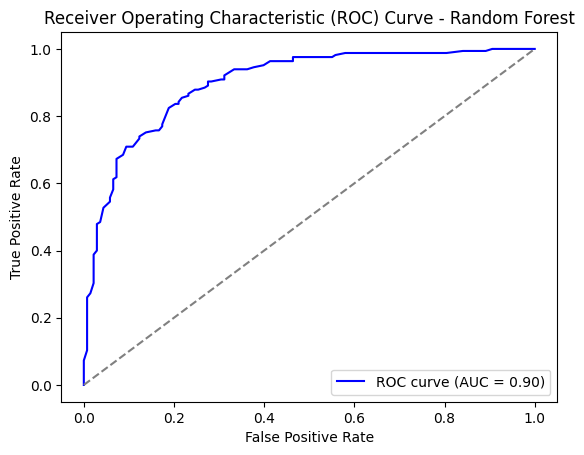

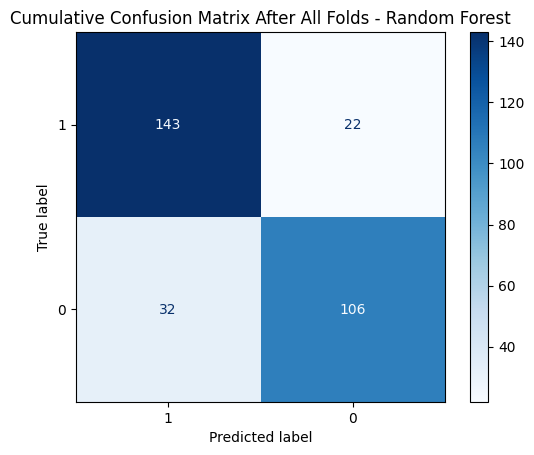

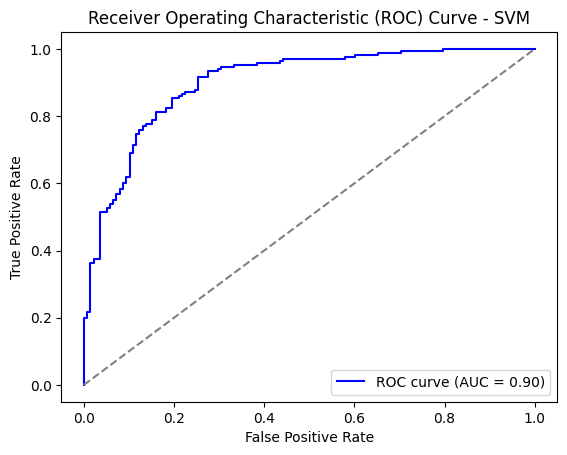

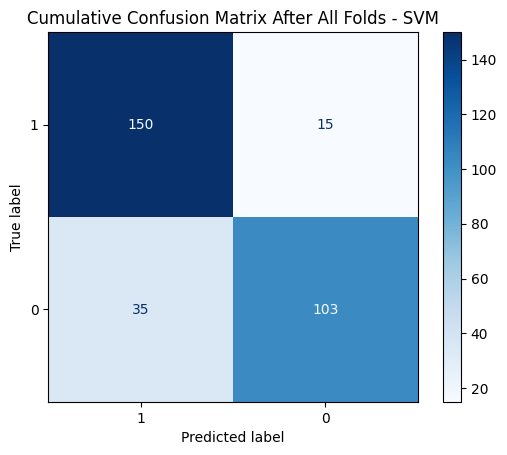

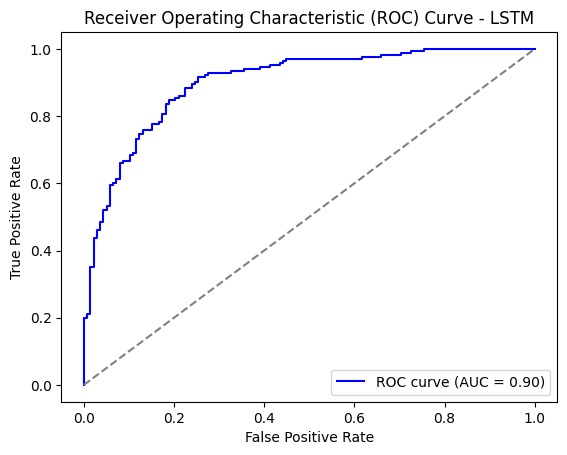

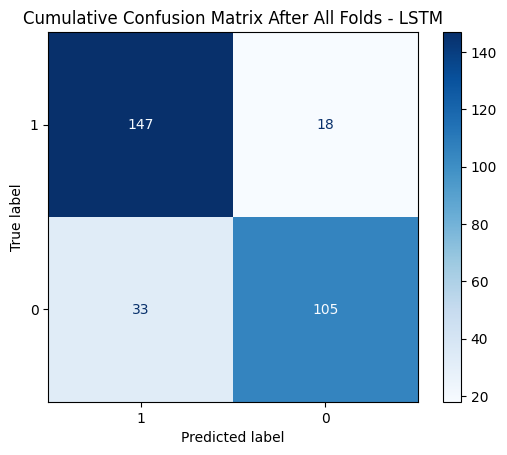

In [74]:
data = pd.read_csv("Data/heart.csv")
pd.set_option('display.width', 100)
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)

X = data.drop('target', axis=1)
Y = data['target']

k_fold(X,Y,10)


#### **Results**

Overall I think the best model is the Random Forest Classifier. After looking at all the metrics from each model through all folds they perform very similar to each other. In addition to this the Confusion Matrix for all the models are also very similar in terms of the amount of FP, FN, TP, and TN. And the last comparison through all folds all 3 models have a very similar ROC curve. So because of this I think the Random Forest Classifier is the best choice due to time. The random forest is able to execute significantly faster than either the Support Vector Machine or the LSTM model and there is no significant decline in any of the measured metrics. This was tested on a dataset with only 13 features and around 300 rows of data so it is possible that with more features one of the models may excel over the other two but based on the heart dataset being used with only 300 rows the Random Forest matches the other models performance and excels over the other two in execution time on such a small dataset so as the dataset grows the execution time difference will be even greater.